<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !if [ -d deepul ]; then rm -Rf deepul; fi
    !git clone -b magda https://github.com/mgswiss15/deepul.git 
    !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
    !pip install ./deepul
else:
    %load_ext autoreload
    %autoreload 2
    import sys
    import pathlib
    cwd = pathlib.Path().absolute()
    sys.path.append(str(cwd.parents[0]))
    sys.path.append(str(cwd.parents[1]))
    print(sys.path)

['/home/magda/Github/deepul/homeworks/hw2', '/home/magda/anaconda3/envs/pytorch/lib/python38.zip', '/home/magda/anaconda3/envs/pytorch/lib/python3.8', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/lib-dynload', '', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions', '/home/magda/.ipython', '/home/magda/Github/deepul/homeworks', '/home/magda/Github/deepul']


In [2]:
from deepul.hw2_helper import *

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


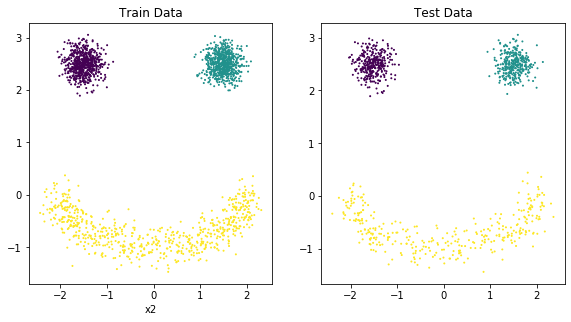

Dataset 2


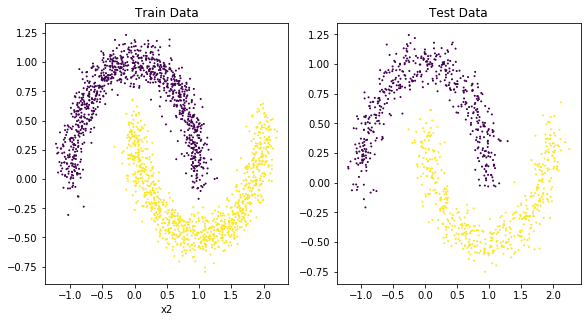

In [3]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (b) RealNVP [15pt]
In this part, we want to train a flow with the following structure: 
$(z_1, z_2) = (f_{\theta, 1} \circ \cdots \circ f_{\theta, n})$, 
where each $f_{\theta, i}$ is an affine transformation of 1 dimension, conditioned on the other, and $z \sim N(0, I)$. According to [Density Estimation Using Real NVP](https://arxiv.org/abs/1605.08803) Section 4.1, there's a particularly good way to parameterize the affine transformation:

Assuming that we're conditioning on $x_1$ and transforming $x_2$, we have 

- $z_1 = x_1$

- $ \text{log_scale} = \text{scale} \times tanh(g_{\theta, \text{scale}}(x_1)) + \text{scale_shift}$

- $z_2 = exp(\text{log_scale}) \times x_2 + g_{\theta, \text{shift}}(x_1)$

where $g_\theta$, $\text{scale}$, and $\text{scale_shift}$ are all learned parameters.


**Train a RealNVP model and provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [18]:
from deepul.exp_utils2 import *
from torch.distributions import Normal, Uniform

class CouplingLayer(nn.Module):
    def __init__(self, n_layers, n_hidden):
        super(CouplingLayer, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        layers_scale = []
        layers_shift = []
        in_feat, out_feat = 1, n_hidden
        for _ in range(self.n_layers):
            layers_scale.append(nn.Linear(in_feat, out_feat))
            layers_shift.append(nn.Linear(in_feat, out_feat))
            in_feat = out_feat
            layers_scale.append(nn.ReLU())
            layers_shift.append(nn.ReLU())
        layers_scale.extend([
            nn.Tanh(),
            nn.Linear(out_feat, 1)
        ])
        layers_shift.append(nn.Linear(out_feat, 1))
        self.scale = nn.Sequential(*layers_scale)
        self.shift = nn.Sequential(*layers_shift)
        
    def coupling(self, in1, in2):
        z1 = in1
        log_scale = self.scale(in1)
        shift = self.shift(in1)
        det = log_scale.exp()  # saving on operations, the determinant here is simple
        z2 = det * in2 + shift
        return torch.cat((z1, z2), dim=1), det
    
    def forward(self, x):
        c1, det1 = self.coupling(x[:,:1], x[:,1:2])
        c2, det2 = self.coupling(c1[:,1:2], c1[:,:1])
        return c2, torch.cat((det1, det2), dim=1)

class SigmoidLayer(nn.Module):
    def __init__(self):
        super(SigmoidLayer, self).__init__()
    
    def forward(self, x):
        z = torch.sigmoid(x)
        det = z * (1 - z)
        return z, det

class RealNVP(nn.Module):
    def __init__(self, n_layers=3, n_hidden=64, n_couplings=5, device='cuda', base_distrib='Normal'):
        super(RealNVP, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_couplings = n_couplings
        self.base_distrib = base_distrib
        self.layers = nn.ModuleList([
            CouplingLayer(self.n_layers, self.n_hidden) for _ in range(n_couplings)
        ])
        if self.base_distrib=='Normal':
            self.base = Normal(torch.tensor([0., 0.], device=device), torch.tensor([1., 1.], device=device))
        elif self.base_distrib=='Uniform':
            self.base = Uniform(torch.tensor([0., 0.], device=device), torch.tensor([1., 1.], device=device))
            self.sigmoid = SigmoidLayer()
        else:
            raise NotImplementedError('Sorry, base distribution can only be Uniform or Normal')
        
    def forward(self, x):
        dets = torch.ones_like(x[:,0:1])
        indata = x
        for layer in self.layers:
            z, d = layer(indata)
            indata = z
            dets = torch.cat((dets, d), dim=1)
        if self.base_distrib == 'Uniform':
            z, d = self.sigmoid(z)
            dets = torch.cat((dets, d), dim=1)
        return z, dets
            
    def log_prob_x_from_z(self, z, dets):
        if self.base_distrib == 'Uniform':
            log_prob = dets.abs().log().sum(dim=1)  # use independent uniform - this breaks
        else:
            log_prob = self.base.log_prob(z).sum(dim=1) + dets.abs().log().sum(dim=1)  # can sum log_probs cause independent
        return log_prob
    
    def loss_function(self, z, dets):
        loss = -self.log_prob_x_from_z(z, dets).mean()
        return loss
    
    def eval_log_prob(self, x):
        self.eval()
        with torch.no_grad():
            z, dets = self(x)
            log_prob = self.log_prob_x_from_z(z, dets)
        return log_prob

#### Note
The uniform implementation seems to crash quite often. I think this happens when some of hte z=1. which in principle should be not a sample from the uniform distribution? Not sure.

In [24]:
def q1_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in R^2. This represents 
      mapping the train set data points through our flow to the latent space. 
    """

    """ YOUR CODE HERE """
    DEVICE = torch.device('cuda')
    train_loader, test_loader = get_loaders(train_data, test_data, bs=128)
    model = RealNVP(n_layers=3, n_hidden=256, n_couplings=10, device=DEVICE, base_distrib='Uniform').to(DEVICE)
    optim_algo = torch.optim.Adam
    nll_train, nll_test = training(
        train_loader, test_loader,
        model, optim_algo, learn_rate=1e-4, device=DEVICE, epochs=100)
    nll_train = np.array(nll_train) / 2
    nll_test = np.array(nll_test) / 2

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = torch.tensor(np.stack([x, y], axis=2).reshape(-1, 2), device=DEVICE, requires_grad=True, dtype=torch.float)
    densities = np.exp(model.eval_log_prob(mesh_xs).detach().cpu().numpy())

    # latents
    train_tensor = torch.tensor(train_data, device=DEVICE, requires_grad=True, dtype=torch.float)
    zs, jacobians = model(train_tensor)
    latents = zs.detach().cpu()
    latents = latents.numpy()
    
    plt.figure()
    plt.hist(latents[:,0], bins=100)
    plt.title('z0')
    plt.show()
    plt.figure()
    plt.hist(latents[:,1], bins=100)
    plt.title('z1')
    plt.show()

    return nll_train, nll_test, densities, latents

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Epoch 0 loss train: 3.246713399887085, test: 3.2697017192840576
Epoch 10 loss train: 1.7793673276901245, test: 1.6477477550506592
Epoch 20 loss train: 1.6322624683380127, test: 1.5368263721466064
Epoch 30 loss train: 1.3133676052093506, test: 1.4925274848937988
Epoch 40 loss train: 1.5335532426834106, test: 1.4676750898361206
Epoch 50 loss train: 1.761507511138916, test: 1.4310965538024902
Epoch 60 loss train: 1.2574138641357422, test: 1.4708763360977173
Epoch 70 loss train: 1.6798964738845825, test: 1.3903895616531372
Epoch 80 loss train: 1.3105597496032715, test: 1.403007984161377
Epoch 90 loss train: 1.3240987062454224, test: 1.5784411430358887


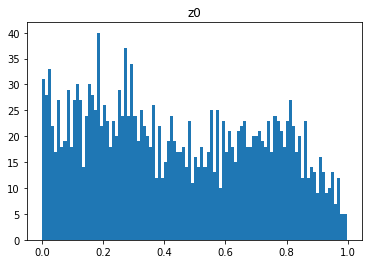

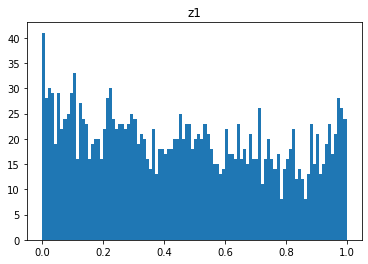

Final Test Loss: 0.7420


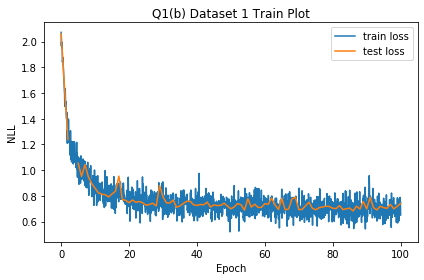

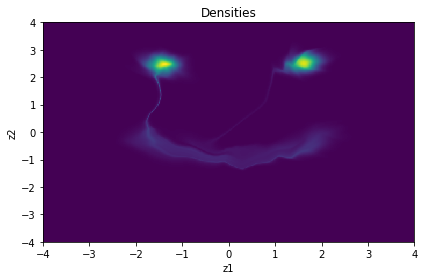

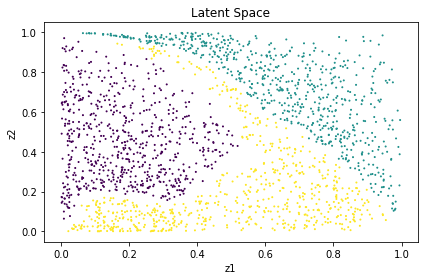

In [25]:
q1_save_results(1, 'b', q1_b)

Epoch 0 loss train: 1.9745028018951416, test: 1.9184364080429077
Epoch 10 loss train: 1.399754524230957, test: 1.298793911933899
Epoch 20 loss train: 1.0840939283370972, test: 1.2073259353637695
Epoch 30 loss train: 1.1915749311447144, test: 1.2813026905059814
Epoch 40 loss train: 1.1921303272247314, test: 1.114467978477478
Epoch 50 loss train: 1.111283779144287, test: 1.0932953357696533
Epoch 60 loss train: 1.2125606536865234, test: 1.0890915393829346
Epoch 70 loss train: nan, test: nan
Epoch 80 loss train: nan, test: nan
Epoch 90 loss train: nan, test: nan


/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6743: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6744: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

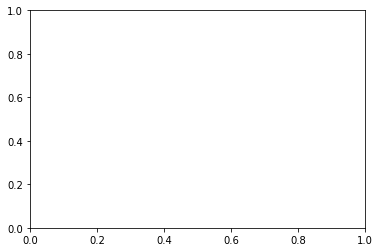

In [26]:
q1_save_results(2, 'b', q1_b)